In [1]:
yellow_path = "/mnt/c/buteo/"
import sys; sys.path.append(yellow_path); sys.path.append(yellow_path + 'buteo/'); sys.path.append(yellow_path + 'buteo/machine_learning/');
import ml_utils

In [2]:
import pandas as pd
import numpy as np
import os
import math

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Tensorflow
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Concatenate, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow_addons as tfa


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
training_data_dir = '/mnt/c/Users/EZRA/Desktop/training_data/64/'
y = np.load(training_data_dir + 'walls_singlepart_64.npy')
X1 = np.load(training_data_dir + 'dtm_aeroe_64.npy')
#X2 = np.load('C:/Users/AFER/Documents/Projects/StoneWalls/Data/stonewalls/Aeroe/training_data/antialiased_data/patches_singlepart/dsm_aeroe_singlepart.npy')
X3 = np.load(training_data_dir + 'hot_aeroe_64.npy')

In [4]:
X = np.stack((X1, X3), axis=3)
print(X.shape)
print(y.shape)

X=X.squeeze()
y=y.squeeze()

print(X.shape)
print(y.shape)


(24782, 64, 64, 2, 1)
(24782, 64, 64, 1)
(24782, 64, 64, 2)
(24782, 64, 64)


In [ ]:
#Remove the extra axis on the stacked array
X = X[..., 0]
print(X.shape)
print(y.shape)

In [ ]:
#If the data used is still with duplicates (previous version of extract_patches version)


#### **Adding ABSENCE data**

In [ ]:
#CREATE PURE PRESENCE BY REMOVING ABSENCES THAT MIGHT EXIST AROUND PATCH EXTRACTION BY THE WALLS

# presence_mask = np.sum(y, axis=(1, 2)) > 0
# X = X[presence_mask]
# y = y[presence_mask]

In [ ]:
# X_absence = np.load('/content/drive/MyDrive/Colab Notebooks/training_data/absence_only/dtm_aeroe_absence.npy')
# y_absence = np.load('/content/drive/MyDrive/Colab Notebooks/training_data/absence_only/absence_rasterized_absence.npy')

# len(X_absence)

In [ ]:
#CHANGE THIS NUMBER HERE TO CHANGE HOW MUCH ABSENCE DATA TO ADD

# #EXAMPLES:
# ADD 500 ABSENCES
# X_absence = X_absence[:500]
# y_absence = y_absence[:500]
# ADD 500 DIFFERENT ABSENCES
# X_absence = X_absence[500:1000]
# y_absence = y_absence[500:1000]

#default is to add no absence (if you check is empty)
# X_absence = X_absence[:0]
# y_absence = y_absence[:0]

In [ ]:
# add the presence and absence data together - if there is no absence then this does nothing, but is fine to run anyway
# X = np.concatenate([X, X_absence])
# y = np.concatenate([y, y_absence])



#### **Proceed here for PRESENCE only**

In [ ]:
# X = ml_utils.add_rotations(X)
# y = ml_utils.add_rotations(y)

In [5]:
# multiply labels by 1000
y = np.multiply(y, 1000)


In [6]:
meta = pd.read_csv(training_data_dir + 'test_area_64.csv')

train_mask = np.swapaxes(meta[meta["test_area"] == 0].values, 0, 1)[0]
test_mask = np.swapaxes(meta[meta["test_area"] == 1].values, 0, 1)[0]

In [7]:
#add the masks to the X and y data in order to create the training and testing areas split
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [8]:
print(X_train.shape)
print(y_train.shape)

(15640, 64, 64, 2)
(15640, 64, 64)


In [9]:
# print(len(X_train))
X_train = ml_utils.add_rotations(X_train)
X_test = ml_utils.add_rotations(X_test)
y_train = ml_utils.add_rotations(y_train)
y_test = ml_utils.add_rotations(y_test)
print(len(X_train))


62560


In [ ]:
# shuffle the datasets. Could be interesting to see if this actually makes a difference, in which case dont run this cell
# np.random.seed(42)
# train_shuffle_mask = np.random.permutation(len(X_train))
# X_train = X_train[train_shuffle_mask]
# y_train = y_train[train_shuffle_mask]

# test_shuffle_mask = np.random.permutation(len(X_test))
# X_test = X_test[test_shuffle_mask]
# y_test = y_test[test_shuffle_mask]

In [10]:
# check all the datasets match up in number
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(62560, 64, 64, 2)
(62560, 64, 64)
(36568, 64, 64, 2)
(36568, 64, 64)


VERIFY THAT THESE TWO IMAGES CORRESPOND

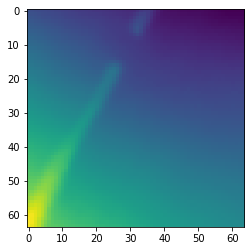

In [24]:
plt.imshow(np.reshape(X_train[2, :, :, 0], (64,64)))

In [20]:
X_train[0, :, :, 0].shape

(64, 64)

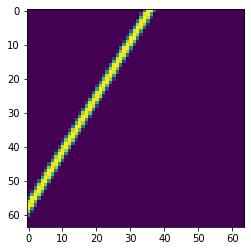

In [23]:
plt.imshow(np.reshape(y_train[2], (64,64)))

# DEFINE AND RUN MODEL

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0

In [30]:

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)
  
  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
  
  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  
  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  
  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  
  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  
  outputs = Conv2D(1, (1, 1), activation='relu')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

shape = (X_train.shape[1:])
shape
input_img = Input(shape, name='img')


model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss= "mse", metrics=["mse", "mae"])

model.summary()


NameError: name 'shape' is not defined

In [51]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-walls.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [52]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,
                    validation_split=0.2)

Epoch 1/10
  54/1564 [>.............................] - ETA: 7:25 - loss: 21389630767.4074 - mse: 21389630767.4074 - mae: 25624.8270

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [ ]:
mse_test = model.evaluate(X_test, y_test)

In [ ]:
import uuid
uid = uuid.uuid4().hex

out_directory = 'C:/Users/AFER/Documents/Projects/StoneWalls/Data/stonewalls/Aeroe/training_data/predictions/'
unique_filename = out_directory + uid + '.h5'
model.save(unique_filename)